<a href="https://colab.research.google.com/github/albertbolanoss/labs_deep_learning/blob/main/notebooks/simpsons-image-classification/01_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simpsons Image Classification.

### 0. Initial Variables

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build


# The Google Drive Folder ID to read / write files
GOOGLE_DRIVE_FOLDER_ID = "1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1"

# The dataset to download from Kaggle
KAGGLE_DATASET = "alexattia/the-simpsons-characters-dataset"

# The directory where the dataset is extracted
KAGGLE_UNZIP_DATASET_DIR = "/content/simpsons_data"

# Source Dataset Directory
SOURCE_DATASET = f"{KAGGLE_UNZIP_DATASET_DIR}/simpsons_dataset"

# The pre processed dataset with labels
PRE_PROCESSED_DATASET = "simpsons_pre_processed_data.npz"

# The train dataset
TRAIN_DATASET = "simpsons_train_data.npz"

# The train dataset
VAL_DATASET = "simpsons_val_data.npz"

# The test dataset
TEST_DATASET = "simpsons_test_data.npz"

# The Image Size (width,height)
IMG_WIDTH = 64
IMG_HEIGHT = 64

# Model parameters
LOG_FILENAME = f"training_log_size_{IMG_WIDTH}.csv"
CHECKPOINT_FILENAME = f"model_checkpoint_{IMG_WIDTH}.keras"
FINAL_MODEL_FILENAME = f"simpsons_model_{IMG_WIDTH}.keras"
BATCH_SIZE = 64
TOTAL_EPOCHS = 50



# Request permissions to access (read/write) the Google Drive Folder ID
auth.authenticate_user()
drive_service = build('drive', 'v3')

print(f"Successful initialization: Dataset: {KAGGLE_DATASET} - Google Drive Id: {GOOGLE_DRIVE_FOLDER_ID}")

Successful initialization: Dataset: alexattia/the-simpsons-characters-dataset - Google Drive Id: 1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1


In [ ]:
from googleapiclient.http import MediaFileUpload
import psutil

def save_dataset(fileName, X, y, class_names):
  np.savez_compressed(fileName, X=X, y=y, labels=class_names)

  file_metadata = {
      'name': fileName,
      'parents': [GOOGLE_DRIVE_FOLDER_ID]
  }
  media = MediaFileUpload(fileName, mimetype='application/octet-stream')

  file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
  print(f"Dataset successfully '{fileName}' stored. ID in Drive: {file.get('id')}")


def load_dataset(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"No found the file '{filename}' in the folder '{folder_id}'.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download progress: {int(status.progress() * 100)}%")

    # Load NumPy data from the memory buffer
    fh.seek(0)
    data = np.load(fh, allow_pickle=True)

    X = data['X']
    y = data['y']
    labels = data['labels']

    print("Data successfully loaded.")
    return X, y, labels


def display_image(x_data, y_data, index, class_names=None):
    """
    Displays an image from the dataset with its numeric and text label.
    """
    img = x_data[index]
    label_raw = y_data[index]

    # 1. Handle One-Hot or Integer labels
    if hasattr(label_raw, '__len__') and len(label_raw) > 1:
        label_id = np.argmax(label_raw)
    else:
        label_id = int(np.array(label_raw).item())

    # 2. Setup Plot
    plt.figure(figsize=(5, 5))

    # If images were normalized (0-1 float), imshow handles it.
    # If they are 0-255 int, we ensure the type is uint8.
    if img.max() > 1.0 and img.dtype != np.uint8:
        img = img.astype(np.uint8)

    plt.imshow(img)

    # 3. Create Title (Numeric ID + Name)
    title = f"Index: {index} | Label ID: {label_id}"

    if class_names is not None:
        try:
            character_name = class_names[label_id]
            title += f"\nCharacter: {character_name.replace('_', ' ').title()}"
        except IndexError:
            title += "\n(Name not found in class_names)"

    plt.title(title)
    plt.axis('off')
    plt.show()

def show_colab_capabilities():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)

  ram_gb = psutil.virtual_memory().total / 1e9

  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

def save_model(filename, model):
    """
    Saves the model locally and uploads/updates it in the specified Google Drive folder.
    """
    # 1. Save locally (in Colab ephemeral environment)
    model.save(filename)
    print(f"Model saved locally as '{filename}'.")

    # 2. Check if the file already exists in the Drive folder
    query = f"name = '{filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id)").execute()
    items = results.get('files', [])

    media = MediaFileUpload(filename, mimetype='application/x-keras')

    # 3. Update or Create
    if items:
        file_id = items[0]['id']
        drive_service.files().update(fileId=file_id, media_body=media).execute()
        print(f"Model updated in Google Drive (ID: {file_id})")
    else:
        file_metadata = {'name': filename, 'parents': [GOOGLE_DRIVE_FOLDER_ID]}
        file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
        print(f"Model created in Google Drive (ID: {file.get('id')})")

def load_dataset_from_drive(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"❌ No se encontró '{filename}' en Drive.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"📥 Descargando dataset: {int(status.progress() * 100)}%")

    fh.seek(0)
    data = np.load(fh, allow_pickle=True)
    print("✅ Dataset cargado exitosamente.")
    return data['X'], data['y'], data['labels']

def sync_file_to_drive(local_path, drive_filename, mimetype='application/octet-stream'):
    """Sube o actualiza un archivo en Google Drive"""
    query = f"name = '{drive_filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id)").execute()
    items = results.get('files', [])

    media = MediaFileUpload(local_path, mimetype=mimetype, resumable=True)

    if items:
        file_id = items[0]['id']
        drive_service.files().update(fileId=file_id, media_body=media).execute()
        return file_id
    else:
        file_metadata = {'name': drive_filename, 'parents': [GOOGLE_DRIVE_FOLDER_ID]}
        file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
        return file.get('id')

def download_file_from_drive(drive_filename, local_path):
    """Descarga un archivo de Drive a la memoria local de Colab si existe"""
    query = f"name = '{drive_filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id)").execute()
    items = results.get('files', [])

    if items:
        file_id = items[0]['id']
        request = drive_service.files().get_media(fileId=file_id)
        with io.FileIO(local_path, 'wb') as fh:
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while not done:
                _, done = downloader.next_chunk()
        return True
    return False

show_colab_capabilities()

Sun Dec 28 02:36:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Download Dataset.

In [ ]:
import os
from google.colab import userdata

# Getting Kaggle credentials and setting in environment
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Download and unzip dataset from Kaggle
!kaggle datasets download -d {KAGGLE_DATASET}
!unzip -q the-simpsons-characters-dataset.zip -d {KAGGLE_UNZIP_DATASET_DIR}

print(f"Downloaded {KAGGLE_DATASET} in {KAGGLE_UNZIP_DATASET_DIR}")

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
 99% 1.06G/1.08G [00:01<00:00, 793MB/s]
100% 1.08G/1.08G [00:01<00:00, 1.06GB/s]
Downloaded alexattia/the-simpsons-characters-dataset in /content/simpsons_data


### 2. Prepare Dataset.

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_simpsons_dataset_with_labels(directory, img_width, img_height):
    print("Loading datasets with labels may take a while")
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_map = {name: i for i, name in enumerate(class_names)}

    # Browse folders
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue

        class_idx = class_map[class_name]

        # Read images from each folder
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Read image with OpenCV
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert BGR (OpenCV) to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize (CNN needs fixed size)
                    img = cv2.resize(img, (img_width, img_height))

                    images.append(img)
                    labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Mix data (Shuffle)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, class_names


X_full, y_full, class_names = load_simpsons_dataset_with_labels(SOURCE_DATASET, IMG_WIDTH, IMG_HEIGHT)
save_dataset(PRE_PROCESSED_DATASET, X_full, y_full, class_names)

print(f"# of samples: {len(X_full)}")
print(f"# of clases: {len(class_names)}: {class_names}")


Loading datasets with labels may take a while


Dataset successfully 'simpsons_pre_processed_data.npz' stored. ID in Drive: 1UErlPTWJppRfuXUQKX73BLH44j2ydCdj
# of samples: 20933
# of clases: 43: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


### 3. Load Pre-processed Dataset from Google Drive

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import numpy as np
import matplotlib.pyplot as plt


X_full, y_full, class_names = load_dataset(GOOGLE_DRIVE_FOLDER_ID, PRE_PROCESSED_DATASET)

print(f"# of samples: {len(X_full)}")
print(f"# of clases: {len(class_names)}: {class_names}")



Download progress: 69%
Download progress: 100%
Data successfully loaded.
# of samples: 20933
# of clases: 43: ['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'simpsons_dataset' 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']


### Show random images

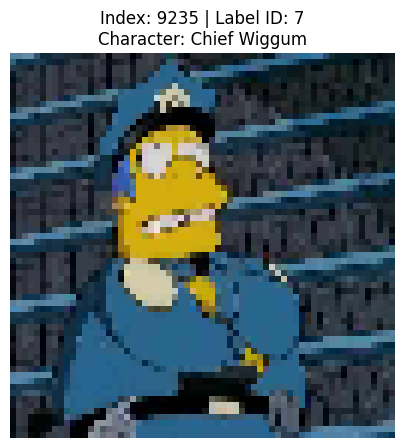

In [ ]:

random_index = np.random.randint(0, len(X_full))
display_image(X_full, y_full, random_index, class_names)

### Show classes distribution

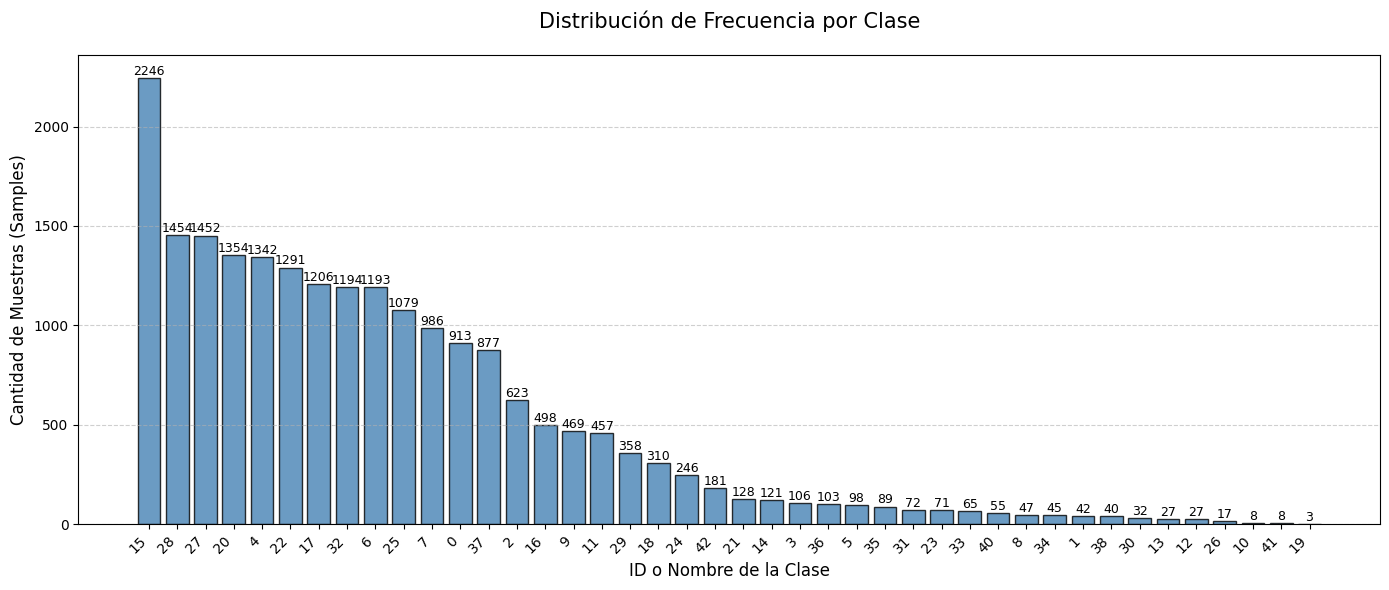

The character with low samples is: lionel_hutz


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def show_class_distribution(y_full):
  unique, counts = np.unique(y_full, return_counts=True)
  df_counts = pd.DataFrame({
      'Clase': unique,
      'Cantidad': counts
  }).sort_values(by='Cantidad', ascending=False)

  # 3. Crear el gráfico
  plt.figure(figsize=(14, 6))
  bars = plt.bar(df_counts['Clase'].astype(str), df_counts['Cantidad'],
                color='steelblue', edgecolor='black', alpha=0.8)

  # Configuración estética para asegurar legibilidad
  plt.title('Distribución de Frecuencia por Clase', fontsize=15, pad=20)
  plt.xlabel('ID o Nombre de la Clase', fontsize=12)
  plt.ylabel('Cantidad de Muestras (Samples)', fontsize=12)
  plt.xticks(rotation=45, ha='right')  # Rotación para evitar que se solapen
  plt.grid(axis='y', linestyle='--', alpha=0.6)

  # Añadir etiquetas de valor sobre cada barra
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()


show_class_distribution(y_full)
print(f"The character with low samples is: {class_names[19]}")

### 4. Feature Engineering

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 0. Reload Dataset to ensure consistency (Reset State)
# This prevents the "inconsistent numbers of samples" error if the cell is re-run.
X_full, y_full, class_names = load_dataset(GOOGLE_DRIVE_FOLDER_ID, PRE_PROCESSED_DATASET)

# 1. Data Normalization
# Convert to float32 and rescale from [0, 255] to [0, 1]
X_full = X_full.astype('float32') / 255.0

# 2. Removing the low sample class (ID 19 - lionel_hutz)
# We look for the index in y_full directly
lionel_hutz_indices = np.where(y_full == 19)[0]

# Remove from X_full and y_full
X_full = np.delete(X_full, lionel_hutz_indices, axis=0)
y_full = np.delete(y_full, lionel_hutz_indices, axis=0)

# 3. Label Encoding
# Now we encode the cleaned y_full
le = LabelEncoder()
y_encoded = le.fit_transform(y_full)

# Class names and number of classes
class_names = le.classes_
num_classes = len(class_names)

# 4. Label One-Hot Encoding
y_categorical = to_categorical(y_encoded, num_classes)

# 5. First Split: 80% Training and 20% Temporary (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full,
    y_categorical,
    test_size=0.20,
    random_state=42,
    stratify=y_categorical  # Maintains the class ratio
)

# 6. Second Split: We divide the temporary 20% in half (10% Val, 10% Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# Check datasets
print(f"Total number of classes detected: {num_classes}")
print("-" * 30)
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val   shape: {X_val.shape}   | y_val   shape: {y_val.shape}")
print(f"X_test  shape: {X_test.shape}  | y_test  shape: {y_test.shape}")

# Save datasets (Corrected filenames and passing class_names)
save_dataset(TRAIN_DATASET, X_train, y_train, class_names)
save_dataset(VAL_DATASET, X_val, y_val, class_names)
save_dataset(TEST_DATASET, X_test, y_test, class_names)

Download progress: 69%
Download progress: 100%
Data successfully loaded.
Total number of classes detected: 41
------------------------------
X_train shape: (16744, 64, 64, 3) | y_train shape: (16744, 41)
X_val   shape: (2093, 64, 64, 3)   | y_val   shape: (2093, 41)
X_test  shape: (2093, 64, 64, 3)  | y_test  shape: (2093, 41)
Dataset successfully 'simpsons_train_data.npz' stored. ID in Drive: 1KWp2l8CoaKx85ZaxCFYEVfv729MpGxsp
Dataset successfully 'simpsons_val_data.npz' stored. ID in Drive: 1i5isy_IvRHzeYPVbTvGlEfuBr6jCr1X6
Dataset successfully 'simpsons_test_data.npz' stored. ID in Drive: 19Uqw3rIBqHSfMZqFhqUMqGtY7IMJvoOK


### 5. Training

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload

# Callback personalizado para subir el LOG a Drive después de cada epoch
class DriveSyncCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        sync_file_to_drive(LOG_FILENAME, LOG_FILENAME, mimetype='text/csv')
        # Opcional: sincronizar también el checkpoint para no perder progreso
        if os.path.exists(CHECKPOINT_FILENAME):
            sync_file_to_drive(CHECKPOINT_FILENAME, CHECKPOINT_FILENAME)
        print(f"\n Progress synchronized with Google Drive.")


initial_epoch = 0
if download_file_from_drive(LOG_FILENAME, LOG_FILENAME):
    try:
        history_df = pd.read_csv(LOG_FILENAME)
        if not history_df.empty:
            initial_epoch = int(history_df['epoch'].max() + 1)
            print(f"🔄 Reanudando desde epoch {initial_epoch}")
            # Intentar descargar pesos previos
            download_file_from_drive(CHECKPOINT_FILENAME, CHECKPOINT_FILENAME)
    except Exception as e:
        print(f"⚠️ Error al procesar logs: {e}")

# ==========================================
# 4. ARQUITECTURA DEL MODELO
# ==========================================
model = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Bloque 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Bloque 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Bloque 4
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Cargar pesos si reanudamos
if initial_epoch > 0 and os.path.exists(CHECKPOINT_FILENAME):
    try:
        model.load_weights(CHECKPOINT_FILENAME)
        print("✅ Pesos cargados correctamente.")
    except:
        print("⚠️ No se pudieron cargar pesos. Iniciando de cero.")
        initial_epoch = 0

# ==========================================
# 5. ENTRENAMIENTO
# ==========================================
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.1)

callbacks = [
    ModelCheckpoint(CHECKPOINT_FILENAME, save_best_only=False),
    CSVLogger(LOG_FILENAME, append=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    DriveSyncCallback() # Sincroniza log y checkpoint a Drive por cada época
]

if initial_epoch < TOTAL_EPOCHS:
    model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=TOTAL_EPOCHS,
        initial_epoch=initial_epoch,
        validation_data=(X_train, y_train), # Cambiar por x_valid si lo tienes separado
        callbacks=callbacks
    )

    # Guardado Final
    model.save(FINAL_MODEL_FILENAME)
    sync_file_to_drive(FINAL_MODEL_FILENAME, FINAL_MODEL_FILENAME, mimetype='application/x-keras')
    print("🏁 Entrenamiento completado y modelo final guardado en Drive.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2520 - loss: 3.4023
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 50s 136ms/step - accuracy: 0.2524 - loss: 3.4000 - val_accuracy: 0.0834 - val_loss: 4.7163
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4791 - loss: 2.0284
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.4793 - loss: 2.0277 - val_accuracy: 0.5159 - val_loss: 1.7057
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6087 - loss: 1.4195
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.6088 - loss: 1.4192 - val_accuracy: 0.7314 - val_loss: 0.9609
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6869 - loss: 1.1074
 Progress synchronized with Google Drive.
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.6869 - loss: 1.1072 - val_accuracy: 0.7363 - val_loss: 0.9679
Epoch 5/50
262/26